# Tutorial 2: Entanglement Forged VQE for the $H_2O$ molecule

In this tutorial, we apply Entanglement Forged VQE to a $H_2O$ molecule. We follow the same format as Tutporial 1 for the $H_2$ molecule, but we also simplify the problem by freezing (removing) some orbitals.

**What new here?**
- Freezing orbitals by specifying the `orbitals_to_reduce` parameter.
- Defing the ansatz using parametrized gates.
- Specifying `spsa_c0` in `EntanglementForgedConfig` to help with conversion.


For comparison, you may wish to review how the ansatz was defined as a `TwoLocal` object, for the case of the $H_2$ molecule, in Tutorial 1.

### Importing the relevant modules

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
from matplotlib import pyplot as plt

from qiskit_nature.drivers import PySCFDriver, Molecule
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit import Aer

import sys
sys.path.append('../../')
from entanglement_forging import EntanglementForgedGroundStateSolver
from entanglement_forging import EntanglementForgedConfig

## Setting up the problem (the chemistry)

We start by setting up the chemical problem. Here, we are considering an H2O molecule. We will put the O atom at the origin and specify the positions of the two H atoms by giving their distance from the origin (radius) and the angle between them. 

In [3]:
radius_1 = 0.958  # position for the first H atom
radius_2 = 0.958  # position for the second H atom
thetas_in_deg = 104.478  # bond angles.

H1_x = radius_1
H2_x = radius_2*np.cos(np.pi/180 * thetas_in_deg)
H2_y = radius_2*np.sin(np.pi/180 * thetas_in_deg)

molecule = Molecule(geometry=[['O', [0., 0., 0.]],
                              ['H', [H1_x, 0., 0.]],
                              ['H', [H2_x, H2_y, 0.0]]], charge=0, multiplicity=1)
driver = PySCFDriver(molecule = molecule, basis='sto6g')
problem = ElectronicStructureProblem(driver)

converter = QubitConverter(JordanWignerMapper())

### Classical Result
For comparison, we also compute the classical result. 

In [4]:
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver, NumPyMinimumEigensolverFactory

solver = GroundStateEigensolver(converter, NumPyMinimumEigensolverFactory(use_default_filter_criterion=False))

result = solver.solve(problem)

print('Classical energy = ', result.total_energies[0])

Classical energy =  -75.72890671869295


## Simplifying the problem (freezing orbitals)

Freezing some orbitals can reduce the execultion time (for discussion of scaling and orbital freezing, refer to the Explanatory Material in the documentation). For water, we freeze orbitals 0 and 3.

In [5]:
orbitals_to_reduce = [0,3]

## Preparing the bitstrings

For a discussion on picking the bitstrings, refer to the Exploratory Material. 

In [6]:
from entanglement_forging import reduce_bitstrings

bitstrings = [[1,1,1,1,1,0,0],[1,0,1,1,1,0,1],[1,0,1,1,1,1,0]]
reduced_bitstrings = reduce_bitstrings(bitstrings, orbitals_to_reduce)

print(f'Bitstrings: {bitstrings}')
print(f'Bitstrings after orbital reduction: {reduced_bitstrings}')

Bitstrings: [[1, 1, 1, 1, 1, 0, 0], [1, 0, 1, 1, 1, 0, 1], [1, 0, 1, 1, 1, 1, 0]]
Bitstrings after orbital reduction: [[1, 1, 1, 0, 0], [0, 1, 1, 0, 1], [0, 1, 1, 1, 0]]


## Preparing the ansatz
Here, we construct the variational form that was used in (https://arxiv.org/abs/2104.10220). The variational form is constructed from several Hop Gates, which we define first. 

In [7]:
from qiskit.circuit import Parameter, QuantumCircuit

theta = Parameter('θ')

hop_gate = QuantumCircuit(2, name="Hop gate")
hop_gate.h(0)
hop_gate.cx(1, 0)
hop_gate.cx(0, 1)
hop_gate.ry(-theta, 0)
hop_gate.ry(-theta, 1)
hop_gate.cx(0, 1)
hop_gate.h(0)

hop_gate.draw()

┌───┐┌───┐     ┌────────────┐     ┌───┐
q_0: ┤ H ├┤ X ├──■──┤ RY(-1.0*θ) ├──■──┤ H ├
     └───┘└─┬─┘┌─┴─┐├────────────┤┌─┴─┐└───┘
q_1: ───────■──┤ X ├┤ RY(-1.0*θ) ├┤ X ├─────
               └───┘└────────────┘└───┘

In [8]:
theta_1, theta_2, theta_3, theta_4 = Parameter('θ1'), Parameter('θ2'), Parameter('θ3'), Parameter('θ4')

ansatz = QuantumCircuit(5)
ansatz.append(hop_gate.to_gate({theta: theta_1}), [0, 1])
ansatz.append(hop_gate.to_gate({theta: theta_2}), [3, 4])
ansatz.append(hop_gate.to_gate({theta: 0}), [1, 4])
ansatz.append(hop_gate.to_gate({theta: theta_3}), [0, 2])
ansatz.append(hop_gate.to_gate({theta: theta_4}), [3, 4])

ansatz.draw('text', justify='right', fold=-1)

┌───────────────┐                ┌───────────────┐
q_0: ┤0              ├────────────────┤0              ├
     │  Hop gate(θ1) │┌──────────────┐│               │
q_1: ┤1              ├┤0             ├┤  Hop gate(θ3) ├
     └───────────────┘│              ││               │
q_2: ─────────────────┤              ├┤1              ├
     ┌───────────────┐│  Hop gate(0) │├───────────────┤
q_3: ┤0              ├┤              ├┤0              ├
     │  Hop gate(θ2) ││              ││  Hop gate(θ4) │
q_4: ┤1              ├┤1             ├┤1              ├
     └───────────────┘└──────────────┘└───────────────┘

## Running the Forged VQE algorithm

### Statevector simulator

We first create an object that contains all the configuration settings, such as the backend, as well as other execution settings.

In [9]:
from entanglement_forging import Log
Log.VERBOSE = False

In [10]:
backend = Aer.get_backend('statevector_simulator')

config = EntanglementForgedConfig(backend = backend, maxiter = 350, spsa_c0 = 20*np.pi, initial_params=[0,0,0,0])

We are now ready to run the calculation and print the results.

In [11]:
calc = EntanglementForgedGroundStateSolver(converter, ansatz, reduced_bitstrings, config, orbitals_to_reduce)
res = calc.solve(problem)

res

Ground state energy (Hartree): -75.70473122463707
Schmidt values: [-0.99357362  0.09928374  0.05435252]
Optimizer parameters: [ 1.06701534  0.64797383  0.04333749 -0.77506443]

Energies (from only one paramset in each iteration):


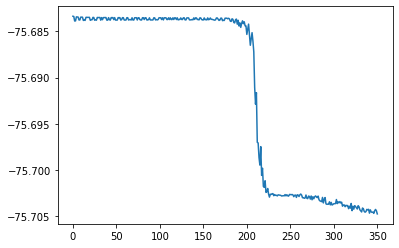

Schmidts (from only one paramset in each iteration):


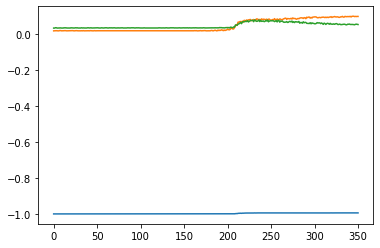

Parameters (from only one paramset in each iteration):


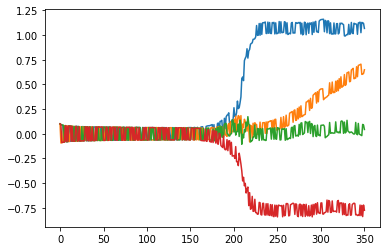

In [12]:
print('Energies (from only one paramset in each iteration):')
plt.plot([e[0] for e in res.get_energies_history()])
plt.show()
print('Schmidts (from only one paramset in each iteration):')
plt.plot([s[0] for s in res.get_schmidts_history()])
plt.show()
print('Parameters (from only one paramset in each iteration):')
plt.plot([p[0] for p in res.get_parameters_history()])
plt.show()